# **<center>SPARC FAIR Codeathon 2022</center>**
<center>
<a href="https://sparc.science">
<img src="https://sparc.science/_nuxt/img/logo-sparc-wave-primary.8ed83a5.svg" alt="SPARC" width="150"/>
</a>
</center>
<center>
<a href="https://sparc.science/help/2022-sparc-fair-codeathon">
<img src="https://images.ctfassets.net/6bya4tyw8399/2qgsOmFnm7wYIfRrPrqbgx/ae3255858aa12bfcebb52e95c7cacffe/codeathon-graphic.png" alt="FAIR" width="75">
</a>
</center>

## <center>Mapping 2D **SPARC** data points to a 3D scaffold: a tutorial</center>


## **Introduction**
Welcome to the Quilted tutorial! We will be demonstrating different features from the [**SPARC**](https://sparc.science/) project. The goal will be to project the 2D locations of neurites in the rat stomach onto a 3D scaffhold of the organ. The data points and the 3D scaffhold will be pulled from **SPARC** datasets. Because the data is [**FAIR**](https://www.nature.com/articles/sdata201618) we will be combining three different datasets of the spatial distribution of the vagal afferents and efferents. 


## **Installing the dependencies**
This tutorial relies on several Python packages that have been developed as part of the **SPARC** project. We will be installing them in order to complete this tutorial.

In [13]:
!pip install pandas # To load SPARC datasets in Python
!pip install openpyxl # Pandas complement for Microsoft Excel files
!pip install ipywidgets # To interact with plotted data
# For data visualisation
!pip install numpy
!pip install numpy-stl
!pip install matplotlib
!pip install ipympl

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## **Retrieving the data**
Now that all the dependencies have been installed we will retrieve the data from directly from the [**SPARC**](https://sparc.science) project website. 
We will be using three datasets:
 * [vagal afferents associated with the myenteric plexus of the rat stomach](https://sparc.science/datasets/10?type=dataset&datasetDetailsTab=files)
 * [vagal afferents within the longitudinal and circular muscle layers of the rat stomach](https://sparc.science/datasets/11?type=dataset&datasetDetailsTab=files)
 * [vagal efferents associated with the myenteric plexus of the rat stomach](https://sparc.science/datasets/12?type=dataset&datasetDetailsTab=files)
 
You can search through all of the **SPARC** datasets [here](https://sparc.science/data?type=dataset) or simply click on the links above to be redirected directly to the datasets. 

It is possible to downlowd the entire dataset by clicking on the purple ***Download full dataset*** button  in the **Download Dataset** tab or selecting specific files and folders in the **Dataset Files** tab lower in the page. If you haven't used the links above, you can click on the purple ***Get Dataset*** button on the left side of the screen or directly in the ***Files*** tab. 

For this tutorial, we are only interested in the contents of the _derative_ folder which contains two .xlsx files: one with the data (IGLE_data.xlsx, IMA_analyzed_data.xlsx, and Efferent_data.xlsx) and a manifest (manifest.xlsx). Enter the _derivative_ folder and select the xlsx file containing the data by ticking the box in front of it. Download the file by clicking the **Download Selected Files and Folders** button at the bottom. You will then be prompted to select the location in which to save it. For each dataset, save it in the _SPARC-tutorial_ folder. 

### **Pennsieve**
[Pennsieve](https://app.pennsieve.io/) is the cloud-based solution for managing, analysing, and sharing scientific **SPARC** datasets.

### **Imports**
Here we import all of the dependencies that we will need to run the code correctly.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from stl import mesh as msh
from mpl_toolkits import mplot3d

### **Helper functions**
Now that we have installed and imported the required dependencies, we are going to define some helper functions.

#### _get\_position_
This function will allow use to convert the position of the data from a percentage into a distance in mm.

In [15]:
def get_position(percent, min_val, max_val):
    """ Converts the position from percentage to distance.
    
    Inputs:
    percent -- float, percentage value.
    min_val -- float, minimum distance for conversion.
    max_val -- float, maximum distance for conversion.
    
    Outputs:
    converted_value -- float, converted value.
    
    """
    return percent / 100 * (max_val - min_val) + min_val 

#### _load\_data_
This function will allow use to extract the correct elements inside the data files and store them into a data frame.

In [ ]:
def load_data(data_name, col_keeps, y_lims, z_lims):
    """ Loads the data from an .xlsx file.
    
    Inputs:
    data_name -- str, nane of the .xlsx file to read.
    col_keeps -- dict{str:str}, dictionnary containing the names of the columns
        to keep.
    y_lims -- list[int], limits for the y direction to convert back to mm,
            first element is the minimum and second is the maximum.
    z_lims -- list[int], limits for the z direction to convert back to mm,
        first element is the minimum and second is the maximum.
    
    Outputs:
    df -- DataFrame, data frame containing the desired data.
    
    """
    df = pd.read_excel(data_name)
    # remove unnecessary columns
    for col in df.columns:
        if col in col_keeps:
            df.rename(columns = {col:col_keeps[col]}, inplace = True)
        else:
            df.drop(col, axis=1, inplace=True)
    df['y'] = get_position(df['%y'], y_lims[0], y_lims[1])
    df['z'] = get_position(df['%x'], z_lims[0], z_lims[1]) # x becomes z
    df['-%y'] = 100 - df['%y']
    # change the area to mm
    return df

#### _map\_to\_3D_
This function will map the 2D data to the 3D mesh.

In [30]:
def map_to_3d(input_pts, input_mesh):
    """ Maps an Nx2 numpy array of points in the y-z plane to have an
    x coordinate based on the nearest point in the y-z plane on the input mesh.
    
    Inputs:
    input_pts -- np.array(N, 2) with y coordinates in column 0, and
        z coordinates in column 1.
    input_mesh -- numpy-stl mesh object with the target mesh.
        
    Outputs:
    out: np.array(N, 3), numpy array with x coordinates in column 0,
        y coordinates in column 1, and z coordinates in column 2.
    
    """
    # Create list of vertices from the vectors of each triangle in the mesh.
    vert = np.around(np.unique(input_mesh.vectors.reshape(
        [int(input_mesh.vectors.size/3), 3]), axis=0),2)
    
    # select only vertices on the ventral stomach
    vert_ventral = vert[vert[:, 0] < 9.0, :]
    # initial output array
    out = np.zeros((input_pts.shape[0], 3))
    
    # iterate over all points in y-z plane and find the closest mesh vertex in this plane
    for i, pt in enumerate(input_pts):      
        min_arg = np.argmin(np.sqrt(np.sum(np.power(
            np.abs((pt-vert_ventral[:, 1:3])),2), 1)))
        matched_x = vert_ventral[min_arg, 0]
        # Add some random movement so that triangles don't obscure points
        matched_x -= 2 - np.random.rand()*1 
        out[i, :] = [matched_x, pt[0], pt[1]]
    return out

### **Loading and preparing the 2D data**
In the 2D datasets that we are using, the distances are in percentages relative to an origin situated in the pyloric end of the stomach for the y-axis and near the oesophagus for the z-axis. We are going to convert those into millimeters instead. For this, we are going to define the limits in the z- and y-axis. 

In [31]:
# Setup maximimum y and z widths.
z_lims = [0, 36.7]
y_lims = [4.6, 0]

col_keeps = {'%x (distance from pylorus side)':'%x', '%y (distance from bottom)':'%y',
             'Average IGLE Area (um²)':'area', 'Area Of Innervation':'area', 
             'Neuron Area Of Innervation (um²) -Convex Hull':'area'}

We can now load the locations of the nerves into DataFrame:

In [23]:
df_igle = load_data('data/IGLE_data.xlsx', col_keeps, y_lims, z_lims)
df_ima = load_data('data/IMA_analyzed_data.xlsx', col_keeps, y_lims, z_lims)
df_efferent = load_data('data/Efferent_data.xlsx', col_keeps, y_lims, z_lims) 

In [25]:
#### Interactive dropdowns for selection of IGLEs, IMAs, efferent neurons (the three different dfs above)
#### it should make data_array=numpy.array (instead of the test data below)
### temporary
data_array = np.array(df_efferent[['y','z','area']])

### **Loading the 3D mesh**
We can now load the 3D stomach mesh. It is provided in the _data_ folder for this tutorial. However, it is possible to use **SPARC** tools to generate the mesh from **FAIR** data. Give link to what tool can be used and the documentation of that tool.

In [29]:
# Load the STL files and add the vectors to the plot
your_mesh = msh.Mesh.from_file('data/stom_surf_mesh.stl')

### **Preparing 3D mesh**
The mesh is loaded with negative coordinates. For commodity, we will recenter it to the orgin of the graph. 

In [ ]:
# with coordinate axes (imported with signs reversed)
your_mesh.x -= np.min(your_mesh.x.flatten())
your_mesh.y -= np.min(your_mesh.y.flatten())
your_mesh.z -= np.min(your_mesh.z.flatten())

In [ ]:
# Convert input data to numpy coordinate array and intensity array.
data_twoDim = np.array(data_array[:, (0,1)])
data_intensity = data_array[:,2]

### **Mapping data**
We are now ready to map the 2D points to the 3D mesh using the helper function we have written earlier. Explain what other tools are available for mapping.

In [ ]:
# Project to 3D stomach surface.
data_threeDim = map_to_3d(data_twoDim, your_mesh)

### **Visualising data**
All is not set to plot the data. We are going to be using the matplotlib package to visualise the data. However, there are **SPARC** tools that use their own GUI to display data. 

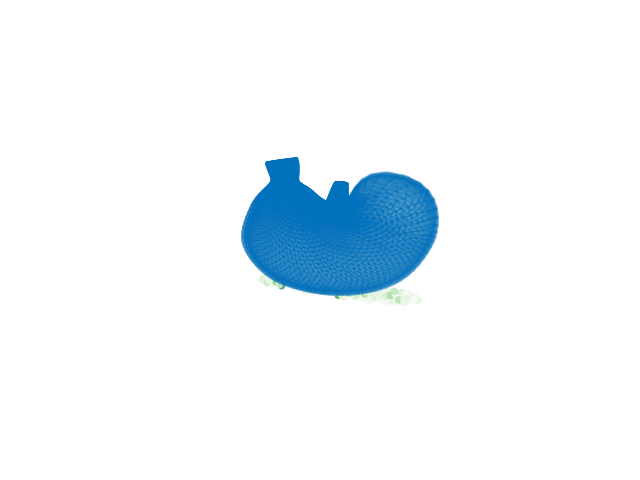

In [28]:
# Enable interactivity in jupyterlab.
%matplotlib widget 

# Start a matplotlib 3d interactive figure.
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Add mesh as triangle polygons to 3d matplotlib view.
faces = mplot3d.art3d.Poly3DCollection(your_mesh.vectors, color=(0, 0.4470, 0.7410))
faces.set_edgecolor((0, 0.4470, 0.7410, 0.1))
faces.set_alpha(0.1)
ax.add_collection3d(faces)

# Plot the projected neurons coloured by their area of innervation.
ax.scatter(data_threeDim[:,0], data_threeDim[:,1], data_threeDim[:,2], 
           Itc=data_intensity, cmap='Greens')

# Scale view to the mesh size and turn off axis chrome.
ax.set_xlim(0,40)
ax.set_ylim(-10,30)
ax.set_zlim(-10,30)
ax.axis('off')

# Show ventral surface and plot projected neurons.
ax.view_init(10, -57, 'y')
plt.show()
